# We're going to build question and answer bot

That allow you to search through youtube transcripts using natural language

In [16]:
pip install --quiet openai tqdm ratelimiter retry


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Download the data
700 videos and 208619 sentences

In [2]:
from datasets import load_dataset

data = load_dataset('jamescalam/youtube-transcriptions', split='train')
data

Found cached dataset json (/Users/changshe/.cache/huggingface/datasets/jamescalam___json/jamescalam--youtube-transcriptions-08d889f6a5386b9b/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


Dataset({
    features: ['title', 'published', 'url', 'video_id', 'channel_id', 'id', 'text', 'start', 'end'],
    num_rows: 208619
})

In [109]:
data.to_pandas().title.nunique()

700

## Prepare context

Create context of 20 sentences

In [12]:
import numpy as np
import pandas as pd

window = 20
stride = 4

In [87]:
def contextualize(raw_df, window, stride):
    def process_video(vid):
        # For each video, create the text rolling window
        text = vid.text.values
        time_end = vid["end"].values
        contexts = vid.iloc[:-window:stride, :].copy()
        contexts["text"] = [' '.join(text[start_i:start_i+window])
                            for start_i in range(0, len(vid)-window, stride)]
        contexts["end"] = [time_end[start_i+window-1]
                            for start_i in range(0, len(vid)-window, stride)]        
        return contexts
    # concat result from all videos
    return pd.concat([process_video(vid) for _, vid in raw_df.groupby("title")])

df = contextualize(data.to_pandas(), 20, 4)

In [88]:
len(df)

48935

## Create embedding function
We'll call the OpenAI embeddings API to get embeddings

In [117]:
import functools
import openai
import ratelimiter
from retry import retry

embed_model = "text-embedding-ada-002"

# API limit at 60/min == 1/sec
limiter = ratelimiter.RateLimiter(max_calls=0.9, period=1.0)

# Get the embedding with retry
@retry(tries=10, delay=1, max_delay=30, backoff=3, jitter=1)
def embed_func(c):    
    rs = openai.Embedding.create(input=c, engine=embed_model)
    return [record["embedding"] for record in rs["data"]]

rate_limited = limiter(embed_func)

In [118]:
from tqdm.auto import tqdm
import math

# We request in batches rather than 1 embedding at a time
def to_batches(arr, batch_size):
    length = len(arr)
    def _chunker(arr):
        for start_i in range(0, len(df), batch_size):
            yield arr[start_i:start_i+batch_size]
    # add progress meter
    yield from tqdm(_chunker(arr), total=math.ceil(length / batch_size))
    
batch_size = 1000
batches = to_batches(df.text.values.tolist(), batch_size)
embeds = [emb for c in batches for emb in rate_limited(c)]

  0%|          | 0/49 [00:00<?, ?it/s]

## Create Lance dataset to support vector search

In [121]:
import lance
import pyarrow as pa
from lance.vector import vec_to_table

table = vec_to_table(np.array(embeds))
combined = pa.Table.from_pandas(df).append_column("vector", table["vector"])
ds = lance.write_dataset(combined, "chatbot.lance")

In [122]:
ds = ds.create_index("vector",
                     index_type="IVF_PQ", 
                     num_partitions=64,  # IVF
                     num_sub_vectors=96)  # PQ

Building vector index: IVF64,OPQ96, metric=l2
Sample 16384 out of 48935 to train kmeans of 1536 dim, 64 clusters


## Create and answer the prompt

In [124]:
def create_prompt(query, context):
    limit = 3750

    prompt_start = (
        "Answer the question based on the context below.\n\n"+
        "Context:\n"
    )
    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )
    # append contexts until hitting limit
    for i in range(1, len(context)):
        if len("\n\n---\n\n".join(context.text[:i])) >= limit:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(context.text[:i-1]) +
                prompt_end
            )
            break
        elif i == len(context)-1:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(context.text) +
                prompt_end
            )    
    return prompt

In [123]:
def complete(prompt):
    # query text-davinci-003
    res = openai.Completion.create(
        engine='text-davinci-003',
        prompt=prompt,
        temperature=0,
        max_tokens=400,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return res['choices'][0]['text'].strip()

# check that it works
query = "who was the 12th person on the moon and when did they land?"
complete(query)

'The 12th person on the moon was Harrison Schmitt, and he landed on December 11, 1972.'

In [125]:
def answer(question):
    emb = embed_func(query)[0]
    context = ds.to_table(
        nearest={
            "column": "vector",
            "k": 3,
            "q": emb,
            "nprobes": 20,
            "refine_factor": 100
        }).to_pandas()
    prompt = create_prompt(question, context)
    return complete(prompt), context.reset_index()

In [126]:
from IPython.display import YouTubeVideo

## Show the answer and show the video at the right place

NLI with multiple negative ranking loss.


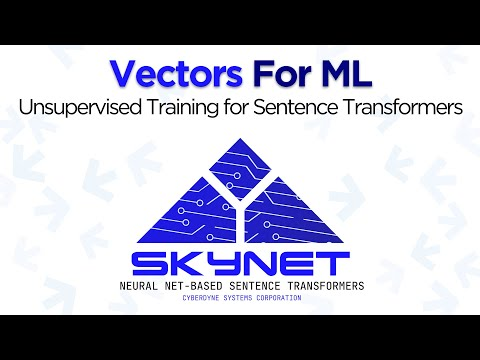

In [127]:
query = ("Which training method should I use for sentence transformers "
         "when I only have pairs of related sentences?")
completion, context = answer(query)

print(completion)
top_match = context.iloc[0]
YouTubeVideo(top_match["url"].split("/")[-1], start=top_match["start"])